<a href="https://colab.research.google.com/github/pymit/NER-LOC-DATE/blob/master/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

useful links:

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

https://www.kaggle.com/navya098/bi-lstm-for-ner


In [0]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!wget "https://nlp.stanford.edu/software/stanford-postagger-full-2018-10-16.zip" -O pos.zip
!unzip pos.zip

In [0]:
!wget "https://nlp.stanford.edu/software/stanford-parser-full-2018-10-17.zip" -O parser.zip
!unzip parser.zip

In [0]:
!wget "https://nlp.stanford.edu/software/stanford-ner-2018-10-16.zip" -O ner.zip
!unzip ner.zip

In [0]:
from nltk.tokenize import word_tokenize
from nltk.tag import StanfordPOSTagger
from nltk.corpus import stopwords
import operator

stanford_dir = "stanford-postagger-full-2018-10-16" 
modelfile = stanford_dir+"/models/english-bidirectional-distsim.tagger"
jarfile=stanford_dir+"/stanford-postagger.jar"
st=StanfordPOSTagger(model_filename=modelfile, path_to_jar=jarfile)

def tokenize_text(text):
    tokens = word_tokenize(text) 
    return tokens

def get_freq(tagged): 
    freq_dist={}
    for word,tag in tagged:
        if word in freq_dist:
            freq_dist[word]+=1
        else:
            freq_dist[word]=1
    return freq_dist

def remove_stopwords(tokens):
    e_stopwords= set(stopwords.words('english'))
    clean_tokens= [tok for tok in tokens if len(tok.lower())>1 and (tok.lower() not in e_stopwords)]
    return clean_tokens
    
def tag_it_now(tagger, tokens):
    clean_tokens = remove_stopwords(tokens)
    tagged_data = tagger.tag(clean_tokens)
    tagged_data = list(set(tagged_data)) 
    return tagged_data

def stanford_pos_tagger(text):
    tokens=tokenize_text(text) 
    return tag_it_now(st, tokens) 

def ori_pos(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent


In [0]:
!pip3 install dateparser
from dateparser import parse as dtpr
from dateparser.search import search_dates
date="tomorrow"
dtpr(date)

# NER

In [0]:
!wget "https://uc0121f3550842e98d60eb763035.dl.dropboxusercontent.com/cd/0/get/Av9PYqIxOyrdr4OkSgdiWObhXvyjGvEp8FnFo5j1kA9RB9GPlKrXPBomsM5PJwqqVXUrABh5rtDj32VeL5P0Jq-dnj2Ph7wg-Epm3PId90YN4aFdvCcuLyNM8oy614pIC6c/file?dl=1#" -O ner_annotated_data.zip
!unzip ner_annotated_data.zip

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('ner.csv',encoding = "ISO-8859-1", error_bad_lines=False)
df.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [0]:
dataset=df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

dataset.head()

,sentence_idx,shape,word,tag
0,1.0,capitalized,Thousands,O
1,1.0,lowercase,of,O
2,1.0,lowercase,demonstrators,O
3,1.0,lowercase,have,O
4,1.0,lowercase,marched,O


In [0]:
dataset=dataset.drop(['shape'],axis=1)

In [0]:
dataset.head()

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [0]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter = SentenceGetter(dataset)
sentences = getter.sentences
(sentences[5])
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


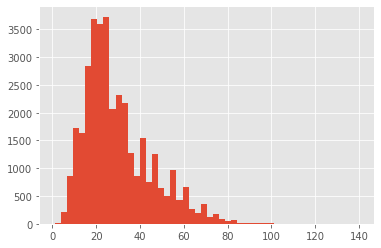

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [0]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [0]:
n_words = len(words); n_words
tags = list(set(dataset["tag"].values))
n_tags = len(tags); n_tags



18

In [0]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [0]:
from keras.preprocessing.sequence import pad_sequences
X =[[word2idx[w[0]] for w in s] for s in sentences]


In [0]:
X = pad_sequences(maxlen=140,sequences=X,padding="post",value=n_words-1)

In [0]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [0]:
y = pad_sequences(maxlen=140,sequences=y,padding="post",value=tag2idx["O"])

In [0]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(X,y,test_size=0.2)

In [0]:
from keras.models import Model,Input 
from keras.layers import LSTM, Embedding,Dense,TimeDistributed,Dropout,Bidirectional


In [0]:
input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [0]:
model  = Model(input,out)
model.summary()

In [0]:
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, np.array(y_train), batch_size=32, epochs=2, validation_split=0.2, verbose=1)
model.save('ner_model.h5')

In [0]:
# i = 0
# p = model.predict(np.array([x_test[i]]))
# p = np.argmax(p, axis=-1)
# print(p)
# print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
# for w,pred in zip(x_test[i],p[0]):
#     print("{:14}: {}".format(words[w],tags[pred]))

In [0]:
# new_model = keras.models.load_model('path_to_my_model.h5')


In [0]:

def finally_working(tellme):
    m = [word2idx[x] for x in tellme.split()]
    n = pad_sequences(maxlen=140,sequences=[m],padding="post",value=n_words-1)
    p = model.predict(np.array([n[0]]))
    p = np.argmax(p, axis=-1)
    res=[]
    for w,pred in zip(n[0],p[0]):
        if tags[pred] !="O":
            res.append((words[w],tags[pred]))
        # print(words[w],tags[pred])
        if words[w] =="ENDPAD":
            break
    return res

In [0]:
testing = "India"
res=finally_working(testing)
tt = ori_pos(testing)
print(res,'\n',tt)

In [302]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('stanford-ner-2018-10-16/classifiers/english.muc.7class.distsim.crf.ser.gz',
					   'stanford-ner-2018-10-16/stanford-ner.jar',
					   encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [0]:
def ori_ner_stan(text):
    tokenized_text = word_tokenize(text)
    classified_text = st.tag(tokenized_text)
    return  classified_text

In [0]:
testing = "at Kalyani"
x=ori_ner_stan(testing)
y = ori_pos(testing)
z=None
for w in testing.split():
    z=dtpr(w)
    if z is not None and w.lower() !="on":
        print(w)
        break

print(x,'\n',y,'\n',z)

In [0]:
def get_loc_n_time(text):
    loc,dt=None,None
    processed_text = ori_ner_stan(text)
    dt = search_dates(text,settings={'DATE_ORDER': 'YMD'})
    for tmp in processed_text:
        if tmp[1] == 'LOCATION':
            loc= tmp[0]
            break
    return loc,dt[0][1]
    



In [309]:
testing = "tomorrow , I will be going to Kalyani"
get_loc_n_time(testing)

('Kalyani', datetime.datetime(2020, 1, 12, 21, 54, 48, 146329))